<a href="https://colab.research.google.com/github/sunnyrvd27/deeplearning_assignment/blob/main/AlphabetSoupCharity_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
from google.colab import files
uploaded = files.upload()


Saving charity_data.csv to charity_data (3).csv


In [3]:
import io

application_df = pd.read_csv(io.BytesIO(uploaded['charity_data.csv']))
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(labels=["EIN", "NAME"], axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [5]:
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

For the optimization, we will bin the following 3 fields "APPLICATION_TYPE", "CLASSIFICATION" and "INCOME_AMT"

In [6]:
application_type = application_df["APPLICATION_TYPE"].value_counts()
application_type

# use the variable name `application_types_to_replace`
application_types_to_replace = list(application_type[application_type < 500].index)

# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [7]:
classification_type = application_df["CLASSIFICATION"].value_counts()
classification_type

# use the variable name `classifications_to_replace`
classifications_to_replace = list(classification_type[classification_type < 1000].index)

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [8]:
application_df.nunique()

APPLICATION_TYPE             9
AFFILIATION                  6
CLASSIFICATION               6
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [9]:
income_amt_type = application_df["INCOME_AMT"].value_counts()
income_amt_type

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

Convert income Amount > 10000 to be merged into "Other"

In [10]:
# use the variable name `ask_amt_to_replace`
imc_amt_to_replace = list(income_amt_type[income_amt_type < 600].index)

# Replace in dataframe
for imc in imc_amt_to_replace:
    application_df['INCOME_AMT'] = application_df['INCOME_AMT'].replace(imc,"Other")
    
# Check to make sure binning was successful
application_df['INCOME_AMT'].value_counts()

0                24388
25000-99999       3747
100000-499999     3374
Other             1107
1M-5M              955
1-9999             728
Name: INCOME_AMT, dtype: int64

USING ONEHOTENCODER TO CREATE FEATURE LIST

In [11]:
# Using OneHotEncoder to create the features
# Generate our categorical variable lists
application_cat = list(application_df.dtypes[application_df.dtypes == "object"].index)
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [12]:
from sklearn.preprocessing import OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_100000-499999,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_Other,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(labels=application_cat, axis=1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_100000-499999,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_Other,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Split our preprocessed data into our features and target arrays
X = application_df.drop("IS_SUCCESSFUL", axis=1).values
y = application_df["IS_SUCCESSFUL"].values.reshape(-1, 1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

MODEL 1: Compile, Train and Evaluate the Model

In [16]:
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 40

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 6,561
Trainable params: 6,561
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=200)

Epoch 1/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5960 - accuracy: 0.7014
Epoch 2/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5764 - accuracy: 0.7187
Epoch 3/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5721 - accuracy: 0.7217
Epoch 4/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5673 - accuracy: 0.7233
Epoch 5/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5629 - accuracy: 0.7246
Epoch 6/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5607 - accuracy: 0.7246
Epoch 7/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5587 - accuracy: 0.7257
Epoch 8/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5575 - accuracy: 0.7262
Epoch 9/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5562 - accuracy: 0.7261
Epoch 10/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5554 - accura

In [18]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5615 - accuracy: 0.7304
Loss: 0.561540961265564, Accuracy: 0.7303789854049683


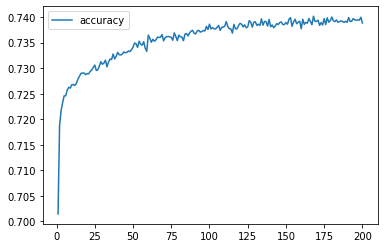

In [19]:
 # Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")

In [50]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization_Model1.h5")

# New Section

MODEL 2: Compile, Train and Evaluate the Model

In [34]:
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 80
hidden_nodes_layer3 = 30
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh")
)
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 80)                3280      
_________________________________________________________________
dense_12 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_13 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 31        
Total params: 12,221
Trainable params: 12,221
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

Epoch 1/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5834 - accuracy: 0.7121
Epoch 2/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5651 - accuracy: 0.7244
Epoch 3/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5598 - accuracy: 0.7263
Epoch 4/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5571 - accuracy: 0.7270
Epoch 5/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5555 - accuracy: 0.7284
Epoch 6/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5547 - accuracy: 0.7290
Epoch 7/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5535 - accuracy: 0.7287
Epoch 8/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5528 - accuracy: 0.7301
Epoch 9/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5522 - accuracy: 0.7291
Epoch 10/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5516 - accuracy: 0.7300

In [36]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5511 - accuracy: 0.7311
Loss: 0.5510879158973694, Accuracy: 0.7310787439346313


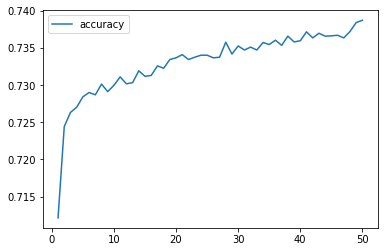

In [37]:
 # Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
# Plot the accuracy
history_df.plot(y="accuracy")

In [51]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization_Model2.h5")

MODEL 3: Compile, Train and Evaluate the Model

In [38]:
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 90
hidden_nodes_layer2 = 80
hidden_nodes_layer3 = 30
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh")
)
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
# Check the structure of the model
nn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 90)                3690      
_________________________________________________________________
dense_16 (Dense)             (None, 80)                7280      
_________________________________________________________________
dense_17 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 31        
Total params: 13,431
Trainable params: 13,431
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=200)

Epoch 1/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5719 - accuracy: 0.7186
Epoch 2/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5605 - accuracy: 0.7273
Epoch 3/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5569 - accuracy: 0.7274
Epoch 4/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5549 - accuracy: 0.7275
Epoch 5/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5538 - accuracy: 0.7293
Epoch 6/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5526 - accuracy: 0.7299
Epoch 7/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5513 - accuracy: 0.7299
Epoch 8/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5504 - accuracy: 0.7311
Epoch 9/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5496 - accuracy: 0.7315
Epoch 10/200
804/804 [==============================] - 2s 2ms/step - loss: 0.5490 - accura

In [40]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5620 - accuracy: 0.7297
Loss: 0.562027096748352, Accuracy: 0.72967928647995


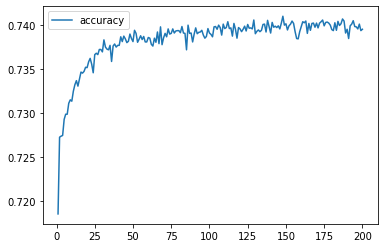

In [41]:
 # Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
# Plot the accuracy
history_df.plot(y="accuracy")

In [52]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization_Model3.h5")

MODEL 4:

In [46]:
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 90
hidden_nodes_layer2 = 90
hidden_nodes_layer3 = 70
hidden_nodes_layer4 = 30
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
# Check the structure of the model
nn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 90)                3690      
_________________________________________________________________
dense_25 (Dense)             (None, 90)                8190      
_________________________________________________________________
dense_26 (Dense)             (None, 90)                8190      
_________________________________________________________________
dense_27 (Dense)             (None, 90)                8190      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 91        
Total params: 28,351
Trainable params: 28,351
Non-trainable params: 0
_________________________________________________________________


In [47]:

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

Epoch 1/50
804/804 [==============================] - 3s 3ms/step - loss: 0.5722 - accuracy: 0.7164
Epoch 2/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5594 - accuracy: 0.7250
Epoch 3/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5573 - accuracy: 0.7258
Epoch 4/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5556 - accuracy: 0.7275
Epoch 5/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5540 - accuracy: 0.7299
Epoch 6/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5530 - accuracy: 0.7292
Epoch 7/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5522 - accuracy: 0.7305
Epoch 8/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5513 - accuracy: 0.7299
Epoch 9/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5504 - accuracy: 0.7308
Epoch 10/50
804/804 [==============================] - 2s 3ms/step - loss: 0.5498 - accuracy: 0.7323

In [48]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5581 - accuracy: 0.7307
Loss: 0.558124303817749, Accuracy: 0.7307288646697998


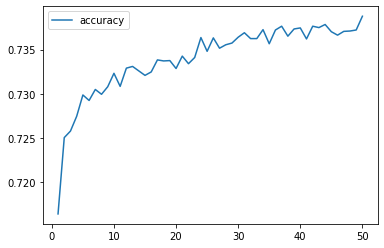

In [49]:
 # Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
# Plot the accuracy
history_df.plot(y="accuracy")

In [53]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization_Model4.h5")

Trying Optimization with Hyperparameter Option

In [20]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=80,
        step=2), activation=activation, input_dim=2))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=60,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [26]:
 # Import the kerastuner library
import kerastuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [27]:
 # Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |relu              |?                 
first_units       |77                |?                 
num_layers        |1                 |?                 
units_0           |11                |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |3                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2


ValueError: ignored